In [1]:
import pandas as pd
import xgboost as xgb

In [2]:
df = pd.read_csv('variable_selected_county_dataset.csv', index_col=0)

In [8]:
df

,date,cases,stay_at_home_announced,stay_at_home_effective,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,...,thunder,tornado,mean_temp_3d_avg,max_temp_3d_avg,min_temp_3d_avg,dewpoint_3d_avg,date_stay_at_home_announced,date_stay_at_home_effective,entity,incremental_cases
190,2020-03-10,20,no,no,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,...,0.0,0.0,61.366667,67.400000,53.600000,47.000000,2020-03-19,2020-03-19,California-Los Angeles,1.0
201,2020-03-11,28,no,no,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,...,0.0,0.0,60.666667,66.800000,54.200000,51.566667,2020-03-19,2020-03-19,California-Los Angeles,8.0
213,2020-03-12,32,no,no,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,...,0.0,0.0,57.033333,62.600000,52.400000,50.833333,2020-03-19,2020-03-19,California-Los Angeles,4.0
225,2020-03-13,40,no,no,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,...,0.0,0.0,53.933333,58.400000,50.600000,50.800000,2020-03-19,2020-03-19,California-Los Angeles,8.0
237,2020-03-14,53,no,no,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,...,0.0,0.0,53.400000,55.400000,51.800000,48.866667,2020-03-19,2020-03-19,California-Los Angeles,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3380,2020-11-30,100650,yes,yes,1947529.0,863.649681,2254.998805,19.945542,3.633687,3.878487,...,0.0,0.0,42.966667,52.633333,33.333333,29.666667,2020-03-31,2020-04-02,Texas-Tarrant,3356.0
3392,2020-12-01,102051,yes,yes,1947529.0,863.649681,2254.998805,19.945542,3.633687,3.878487,...,0.0,0.0,43.166667,54.300000,32.666667,26.733333,2020-03-31,2020-04-02,Texas-Tarrant,1401.0
3404,2020-12-02,103781,yes,yes,1947529.0,863.649681,2254.998805,19.945542,3.633687,3.878487,...,0.0,0.0,43.133333,53.266667,34.366667,30.100000,2020-03-31,2020-04-02,Texas-Tarrant,1730.0
3416,2020-12-03,105675,yes,yes,1947529.0,863.649681,2254.998805,19.945542,3.633687,3.878487,...,0.0,0.0,42.400000,47.633333,36.700000,33.633333,2020-03-31,2020-04-02,Texas-Tarrant,1894.0


In [9]:
dfToUse = df.drop(labels=['cases'],axis=1)
dfToUse = dfToUse[dfToUse['entity'] == 'Illinois-Cook']

In [16]:
toDrop = dfToUse.columns[dfToUse.nunique() == 1].tolist()
toDrop.pop()
dfToUse.drop(labels=toDrop, axis=1, inplace=True)

In [17]:
train = dfToUse[dfToUse['date'] < '2020-10-26'].sort_values(by=['date']).reset_index().drop(labels=['index'],axis=1)
test = dfToUse[dfToUse['date'] >= '2020-10-26']
train.date = pd.to_datetime(train.date)
train['month'] = train.date.dt.month
train['day'] = train.date.dt.day

test.date = pd.to_datetime(test.date)
test['month'] = test.date.dt.month
test['day'] = test.date.dt.day

C:\Users\Albert Song\AppData\Local\Temp\ipykernel_27420\3474772313.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.date = pd.to_datetime(test.date)
C:\Users\Albert Song\AppData\Local\Temp\ipykernel_27420\3474772313.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test.date.dt.month
C:\Users\Albert Song\AppData\Local\Temp\ipykernel_27420\3474772313.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [18]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import numpy as np

#train.reset_index(inplace=True)

n_splits = 3

tscv = TimeSeriesSplit(n_splits=n_splits)

In [19]:
yTrain = train['incremental_cases']
xTrain = train.drop(labels=['incremental_cases', 'date'],axis=1)


In [20]:
finalXTrain = pd.get_dummies(xTrain)

In [21]:
nEst = [2500, 5000, 7500]
lr = [0.001,0.1,0.5]
md = [4,6,8]
ss = [0.1,0.5,0.8]
rl = [0,1]
gam = [0,0.1,1]
best_score, best_cfg = float("inf"), None
for n in nEst:
    for l in lr:
        for m in md:
            for s in ss:
                for r in rl:
                    for g in gam:
                        eval = (n,l,m,s,r,g)
                        avg = 0
                        print(eval)
                        for train_index, val_index in tscv.split(finalXTrain):
                            train_data, val_data = finalXTrain.loc[train_index], finalXTrain.loc[val_index]
                            yFit = yTrain.loc[train_index]
                            yVal = yTrain.loc[val_index]
                            model = xgb.XGBRegressor(n_estimators=n, learning_rate=l, max_depth=m, subsample=s, reg_lambda=r, gamma=g)
                            model.fit(train_data, yFit)
                            forecast = model.predict(val_data)
                            mse = mean_squared_error(yVal, forecast)
                            avg += mse
                        if avg < best_score:
                            best_score, best_cfg = avg, eval

(2500, 0.001, 4, 0.1, 0, 0)
(2500, 0.001, 4, 0.1, 0, 0.1)
(2500, 0.001, 4, 0.1, 0, 1)
(2500, 0.001, 4, 0.1, 1, 0)
(2500, 0.001, 4, 0.1, 1, 0.1)
(2500, 0.001, 4, 0.1, 1, 1)
(2500, 0.001, 4, 0.5, 0, 0)
(2500, 0.001, 4, 0.5, 0, 0.1)
(2500, 0.001, 4, 0.5, 0, 1)
(2500, 0.001, 4, 0.5, 1, 0)
(2500, 0.001, 4, 0.5, 1, 0.1)
(2500, 0.001, 4, 0.5, 1, 1)
(2500, 0.001, 4, 0.8, 0, 0)
(2500, 0.001, 4, 0.8, 0, 0.1)
(2500, 0.001, 4, 0.8, 0, 1)
(2500, 0.001, 4, 0.8, 1, 0)
(2500, 0.001, 4, 0.8, 1, 0.1)
(2500, 0.001, 4, 0.8, 1, 1)
(2500, 0.001, 6, 0.1, 0, 0)
(2500, 0.001, 6, 0.1, 0, 0.1)
(2500, 0.001, 6, 0.1, 0, 1)
(2500, 0.001, 6, 0.1, 1, 0)
(2500, 0.001, 6, 0.1, 1, 0.1)
(2500, 0.001, 6, 0.1, 1, 1)
(2500, 0.001, 6, 0.5, 0, 0)
(2500, 0.001, 6, 0.5, 0, 0.1)
(2500, 0.001, 6, 0.5, 0, 1)
(2500, 0.001, 6, 0.5, 1, 0)
(2500, 0.001, 6, 0.5, 1, 0.1)
(2500, 0.001, 6, 0.5, 1, 1)
(2500, 0.001, 6, 0.8, 0, 0)
(2500, 0.001, 6, 0.8, 0, 0.1)
(2500, 0.001, 6, 0.8, 0, 1)
(2500, 0.001, 6, 0.8, 1, 0)
(2500, 0.001, 6, 0.8, 1, 0

In [23]:
print(best_score, best_cfg)

705893.565324325 (2500, 0.001, 4, 0.1, 1, 0)


In [24]:
nEst = [2500]
lr = [0.001]
md = [2,3,4]
ss = [0.1,0.5,0.3]
rl = [0.5,1]
gam = [0.01,0,0.001]
best_score, best_cfg = float("inf"), None
for n in nEst:
    for l in lr:
        for m in md:
            for s in ss:
                for r in rl:
                    for g in gam:
                        eval = (n,l,m,s,r,g)
                        avg = 0
                        print(eval)
                        for train_index, val_index in tscv.split(finalXTrain):
                            train_data, val_data = finalXTrain.loc[train_index], finalXTrain.loc[val_index]
                            yFit = yTrain.loc[train_index]
                            yVal = yTrain.loc[val_index]
                            model = xgb.XGBRegressor(n_estimators=n, learning_rate=l, max_depth=m, subsample=s, reg_lambda=r, gamma=g)
                            model.fit(train_data, yFit)
                            forecast = model.predict(val_data)
                            mse = mean_squared_error(yVal, forecast)
                            avg += mse
                        if avg < best_score:
                            best_score, best_cfg = avg, eval

(2500, 0.001, 2, 0.1, 0.5, 0.01)
(2500, 0.001, 2, 0.1, 0.5, 0)
(2500, 0.001, 2, 0.1, 0.5, 0.001)
(2500, 0.001, 2, 0.1, 1, 0.01)
(2500, 0.001, 2, 0.1, 1, 0)
(2500, 0.001, 2, 0.1, 1, 0.001)
(2500, 0.001, 2, 0.5, 0.5, 0.01)
(2500, 0.001, 2, 0.5, 0.5, 0)
(2500, 0.001, 2, 0.5, 0.5, 0.001)
(2500, 0.001, 2, 0.5, 1, 0.01)
(2500, 0.001, 2, 0.5, 1, 0)
(2500, 0.001, 2, 0.5, 1, 0.001)
(2500, 0.001, 2, 0.3, 0.5, 0.01)
(2500, 0.001, 2, 0.3, 0.5, 0)
(2500, 0.001, 2, 0.3, 0.5, 0.001)
(2500, 0.001, 2, 0.3, 1, 0.01)
(2500, 0.001, 2, 0.3, 1, 0)
(2500, 0.001, 2, 0.3, 1, 0.001)
(2500, 0.001, 3, 0.1, 0.5, 0.01)
(2500, 0.001, 3, 0.1, 0.5, 0)
(2500, 0.001, 3, 0.1, 0.5, 0.001)
(2500, 0.001, 3, 0.1, 1, 0.01)
(2500, 0.001, 3, 0.1, 1, 0)
(2500, 0.001, 3, 0.1, 1, 0.001)
(2500, 0.001, 3, 0.5, 0.5, 0.01)
(2500, 0.001, 3, 0.5, 0.5, 0)
(2500, 0.001, 3, 0.5, 0.5, 0.001)
(2500, 0.001, 3, 0.5, 1, 0.01)
(2500, 0.001, 3, 0.5, 1, 0)
(2500, 0.001, 3, 0.5, 1, 0.001)
(2500, 0.001, 3, 0.3, 0.5, 0.01)
(2500, 0.001, 3, 0.3, 0.5, 

In [25]:
print(best_score, best_cfg)

705893.565324325 (2500, 0.001, 4, 0.1, 1, 0.01)


In [26]:
model = xgb.XGBRegressor(n_estimators=2500, learning_rate=0.001, max_depth=4, subsample=0.1, reg_lambda=1, gamma=0.01)

model.fit(finalXTrain, yTrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [30]:
yTest = test[['incremental_cases', 'entity', 'date']]
xTest = test.drop(labels=['incremental_cases', 'date'],axis=1)
xTest = pd.get_dummies(xTest)
xTest['stay_at_home_announced_no'] = False
xTest['stay_at_home_effective_no'] = False
xTest['precip_flag_A'] = False
xTest['precip_flag_I'] = False
xTest = xTest[finalXTrain.columns]

In [111]:
xTest

,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,food_environment_index,...,entity_California-San Diego,entity_Florida-Miami-Dade,entity_Illinois-Cook,entity_Nevada-Clark,entity_New York-Nassau,entity_New York-New York City,entity_New York-Suffolk,entity_Pennsylvania-Philadelphia,entity_Texas-Harris,entity_Texas-Tarrant
2949,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,7.133827,10.847678,21.7,8.5,...,False,False,False,False,False,False,False,False,False,False
2961,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,7.133827,10.847678,21.7,8.5,...,False,False,False,False,False,False,False,False,False,False
2973,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,7.133827,10.847678,21.7,8.5,...,False,False,False,False,False,False,False,False,False,False
2985,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,7.133827,10.847678,21.7,8.5,...,False,False,False,False,False,False,False,False,False,False
2997,10057155.0,4058.183382,2478.240645,16.418669,3.550138,3.616494,7.133827,10.847678,21.7,8.5,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3380,1947529.0,863.649681,2254.998805,19.945542,3.633687,3.878487,8.344893,14.049000,29.5,7.0,...,False,False,False,False,False,False,False,False,False,True
3392,1947529.0,863.649681,2254.998805,19.945542,3.633687,3.878487,8.344893,14.049000,29.5,7.0,...,False,False,False,False,False,False,False,False,False,True
3404,1947529.0,863.649681,2254.998805,19.945542,3.633687,3.878487,8.344893,14.049000,29.5,7.0,...,False,False,False,False,False,False,False,False,False,True
3416,1947529.0,863.649681,2254.998805,19.945542,3.633687,3.878487,8.344893,14.049000,29.5,7.0,...,False,False,False,False,False,False,False,False,False,True


In [31]:
preds = model.predict(xTest)

In [32]:
mse = mean_squared_error(preds, yTest.incremental_cases)
mse

9131541.447773237

In [33]:
yTest['preds'] = preds

C:\Users\Albert Song\AppData\Local\Temp\ipykernel_27420\4113693813.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yTest['preds'] = preds


In [34]:
yTest

,incremental_cases,entity,date,preds
2953,1879.0,Illinois-Cook,2020-10-26,840.068237
2965,1367.0,Illinois-Cook,2020-10-27,873.845337
2977,2276.0,Illinois-Cook,2020-10-28,961.321655
2989,2541.0,Illinois-Cook,2020-10-29,1073.308960
3001,2756.0,Illinois-Cook,2020-10-30,945.408813
3013,0.0,Illinois-Cook,2020-10-31,958.149170
3025,6697.0,Illinois-Cook,2020-11-01,1038.314575
3037,2638.0,Illinois-Cook,2020-11-02,928.910767
3049,2444.0,Illinois-Cook,2020-11-03,1209.949829
3061,2992.0,Illinois-Cook,2020-11-04,1014.162903


In [37]:
from sklearn.metrics import r2_score

r2_score(yTest.incremental_cases, yTest.preds)

-4.322778427582693

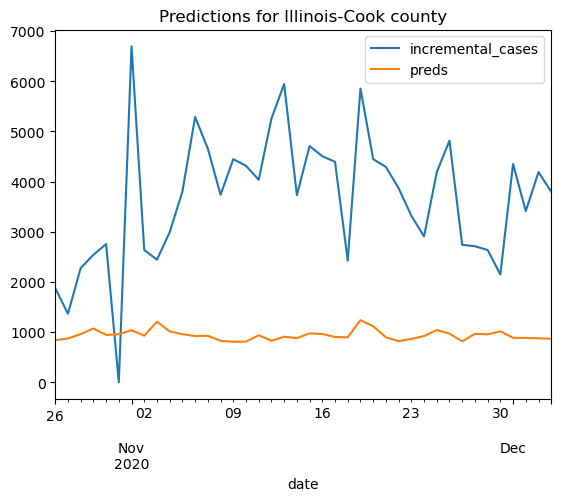

In [35]:
for x in yTest.entity.unique():
    dfPlot = yTest[yTest['entity'] == x].drop(labels=['entity'], axis=1)
    dfPlot.plot(x='date', title=str('Predictions for ' + x + ' county'))